In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import rioxarray 
import os
import matplotlib as mpl
import seaborn as sns
import warnings


In [2]:
crops = ['Corn', 'Soybean', "Wheat", "Rice"]
phases = [1,2]

In [5]:
# Read in the data
gdf_dict = {}
for crop in crops:
    for phase in phases:
        rds = rioxarray.open_rasterio(
            "../" + os.sep + "processed" + os.sep + "output" + os.sep + crop + "_phase_" + str(phase) + "_rc_mean.asc"
        )
        rds = rds.squeeze().drop("spatial_ref").drop("band")
        rds.name = "data"
        df = rds.to_dataframe().reset_index().replace(-9, np.nan).dropna()
        #df = df.head(500)
        # Convert to geodataframe
        gdf_dict[crop+str(phase)] = df
        

In [4]:
def dataframe_to_geopandas(df):
    # Convert the x and y columns to longitude and latitude, respectively
    geometry = [Point(x, y) for x, y in zip(df['x'], df['y'])]
    
    # Create a GeoDataFrame from the geometry and data columns
    gdf = gpd.GeoDataFrame(df['data'], geometry=geometry)
    
    return gdf


In [5]:
# Convert the dataframes to geodataframes
gdf_dict_gpd = {}
for i in gdf_dict.keys():
    gdf_dict_gpd[i] = dataframe_to_geopandas(gdf_dict[i])

In [6]:
regions = gpd.read_file("regions" + os.sep + "ne_10m_admin_0_countries_lakes.shp")
regions = regions[(regions['CONTINENT'] != 'Antarctica') & (regions['CONTINENT'] != 'Seven seas (open ocean)')]
regions = regions[["CONTINENT", "geometry"]]
# Dissolve the geometries by region
regions = regions.dissolve(by="CONTINENT")
regions = regions.reset_index()
regions.to_crs("EPSG:4326", inplace=True)

In [7]:
region_yield_reduction_data = {"region":[], "crop":[], "phase":[], "yield_reduction":[]}
crop_phases = [(crop, phase) for crop in crops for phase in phases]
# Suppress the FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

for region in regions["CONTINENT"]:
    print(region)
    region_subset = regions[regions['CONTINENT'] == region]
    for crop, phase in crop_phases:
        print(crop, phase)
        region_yield_reduction_data["region"].append(region)
        region_yield_reduction_data["crop"].append(crop)
        region_yield_reduction_data["phase"].append(phase)
        yield_reduction = gdf_dict_gpd[crop + str(phase)].copy()
        yield_reduction.crs = "EPSG:4326"

        merged_gdf = gpd.sjoin(yield_reduction, region_subset, how="inner", op="intersects")
        # Calculate average values by continent
        merged_gdf["data"] = merged_gdf["data"] * 100
        reduction = merged_gdf["data"].mean()
        region_yield_reduction_data["yield_reduction"].append(reduction)

region_yield_reduction = pd.DataFrame(region_yield_reduction_data)


Africa
Corn 1
Corn 2
Soybean 1
Soybean 2
Wheat 1
Wheat 2
Rice 1
Rice 2
Asia
Corn 1
Corn 2
Soybean 1
Soybean 2
Wheat 1
Wheat 2
Rice 1
Rice 2
Europe
Corn 1
Corn 2
Soybean 1
Soybean 2
Wheat 1
Wheat 2
Rice 1
Rice 2
North America
Corn 1
Corn 2
Soybean 1
Soybean 2
Wheat 1
Wheat 2
Rice 1
Rice 2
Oceania
Corn 1
Corn 2
Soybean 1
Soybean 2
Wheat 1
Wheat 2
Rice 1
Rice 2
South America
Corn 1
Corn 2
Soybean 1
Soybean 2
Wheat 1
Wheat 2
Rice 1
Rice 2


In [8]:
# change phase to string
region_yield_reduction["phase"] = region_yield_reduction["phase"].astype(str)
region_yield_reduction.columns = ["Continent", "Crop", "Phase", "Yield Reduction (%)"]


In [17]:
region_yield_reduction.groupby("Phase").mean()

,Yield Reduction (%)
Phase,
1,-17.950680
2,-30.337861


In [20]:
region_yield_reduction.groupby(["Crop"]).mean()

,Yield Reduction (%)
Crop,
Corn,-24.521780
Rice,-27.526241
Soybean,-16.356991
Wheat,-26.874189


In [19]:
region_yield_reduction.groupby(["Crop", "Phase"]).mean()

Yield Reduction (%)
Crop    Phase                     
Corn    1               -16.807473
        2               -32.236088
Rice    1               -24.697628
        2               -30.354854
Soybean 1                -8.213625
        2               -24.500357
Wheat   1               -20.461151
        2               -33.287227

In [21]:
region_yield_reduction.groupby(["Continent"]).mean()

,Yield Reduction (%)
Continent,
Africa,-11.359229
Asia,-21.022537
Europe,-25.153289
North America,-30.222980
Oceania,-35.901519
South America,-24.145380


In [22]:
region_yield_reduction.groupby(["Continent", "Phase"]).mean()

Yield Reduction (%)
Continent     Phase                     
Africa        1                -9.825578
              2               -12.892880
Asia          1               -18.792271
              2               -23.252804
Europe        1               -16.714420
              2               -33.592157
North America 1               -21.130984
              2               -39.314976
Oceania       1               -27.518324
              2               -44.284715
South America 1               -16.114413
              2               -32.176347

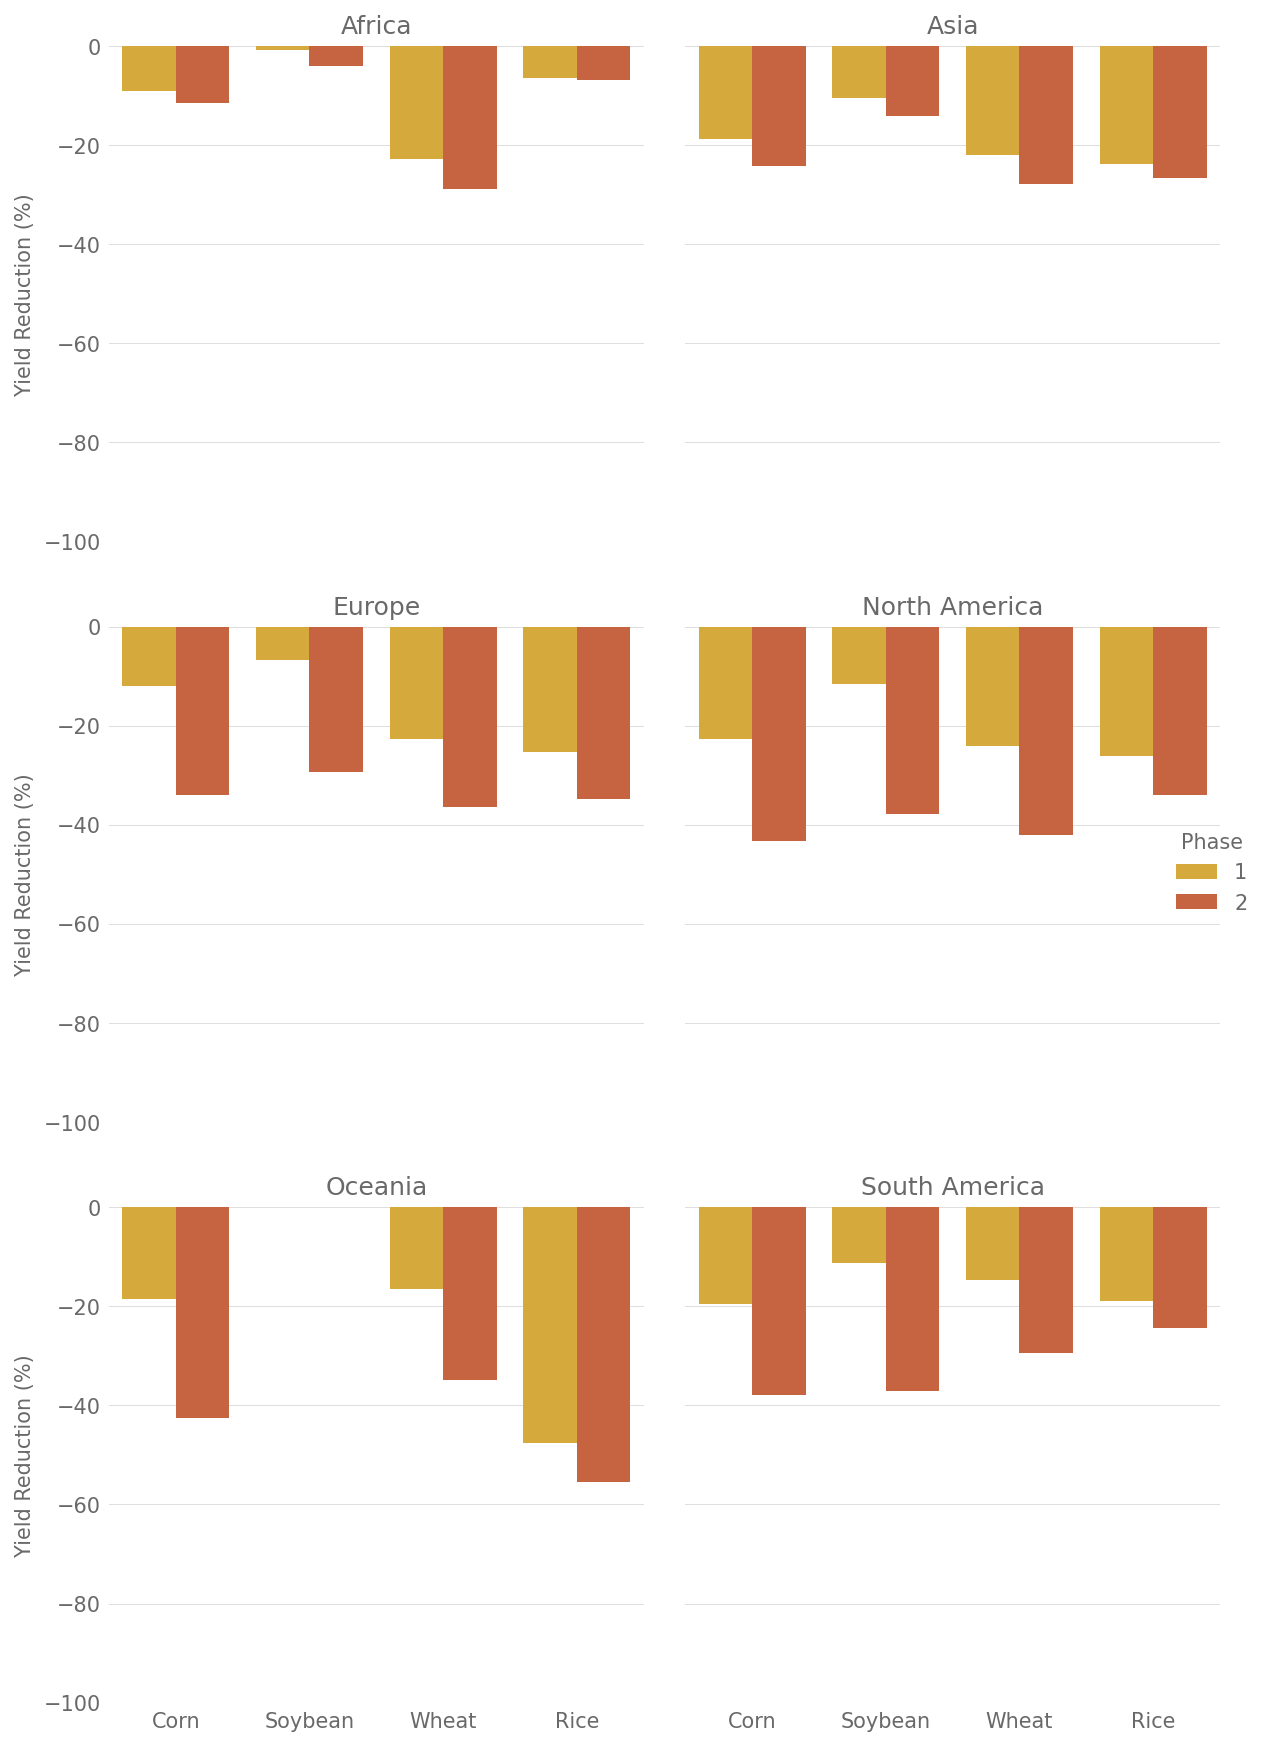

In [14]:


plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")
# Set up the figure and subplots
g = sns.catplot(
        data=region_yield_reduction,
        x='Crop',
        y='Yield Reduction (%)',
        col="Continent",
        hue='Phase',
        kind='bar',
        height=4,
        aspect=1,
        col_wrap=2,
        palette= ['#F0B323', '#DC582A']
    )

# Set the titles for each subplot
for ax in g.axes.flat:
    region = ax.get_title().split(' = ')[1]
    ax.set_title(region)
    ax.set_ylim(-100, 0)
    ax.set_ylabel("Yield Reduction (%)")
    ax.set_xlabel("")
    # Hide borders
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # Set the legend title

# Adjust the spacing between subplots
g.fig.tight_layout(pad=2)

# Show the plot
plt.savefig("yield_reduction_by_region.png", dpi=300, bbox_inches='tight')